# Sentiment Analysis (using LSTM, GRU)

In [ ]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
!pip install contractions
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
import contractions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DL/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


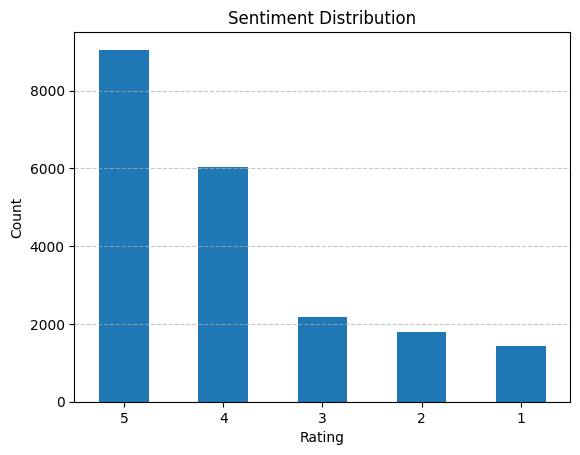

In [ ]:
# Count the occurrences of each sentiment
sentiment_distribution = df['Rating'].value_counts()

# Plot the sentiment distribution
sentiment_distribution.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

In [ ]:
# Check class distribution
df['Sentiment'].value_counts()

,count
Sentiment,
positive,15093
negative,3214
neutral,2184


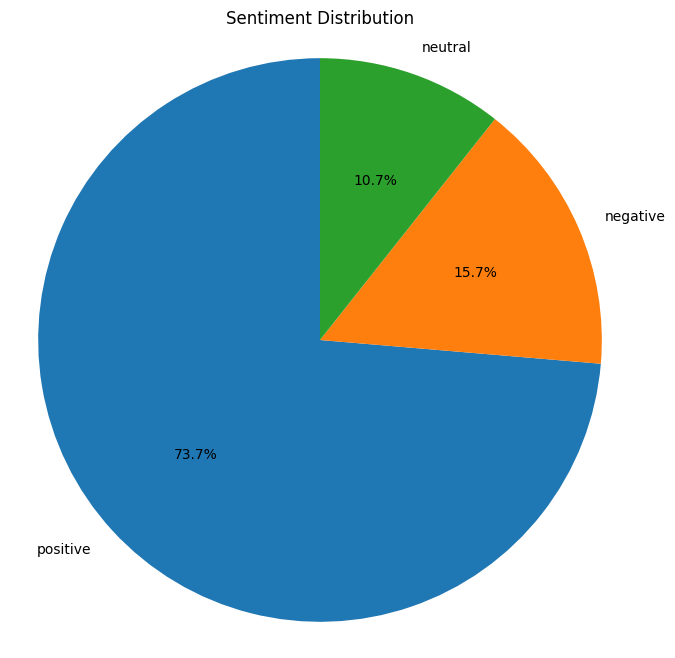

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' and 'sentiment_distribution' are defined as in the previous code

sentiment_distribution = df['Sentiment'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df['Sentiment']), y=df['Sentiment'])

In [ ]:
# prompt: print class_weights

class_weights


array([2.1251815 , 3.127442  , 0.45254975])

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Efficient for lemmatization

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Expanding contractions
    text = contractions.fix(text)

    # Removing file paths and URLs
    text = re.sub(r'http\S+|www\S+|[a-zA-Z]:\\[^\s]*', '', text)

    # Removing HTML tags if any exist
    if "<" in text and ">" in text:  # Basic check for HTML tags
        text = BeautifulSoup(text, features="html.parser").get_text()

    # Removing punctuation and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Removing stop words and lemmatizing
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    # Handling negations
    text = " ".join(words).replace("n't", " not").replace("'re", " are").replace("'s", " is")

    # Removing extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applying preprocessing to all reviews
df['cleaned_review'] = df['Review'].apply(preprocess_text)


In [ ]:
df

,Review,Rating,Sentiment,cleaned_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...
...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,positive,best kept secret rd time staying charm star ca...
20487,great location price view hotel great quick pl...,4,positive,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,negative,ok look nice modern outside desk staff nt part...
20489,hotel theft ruined vacation hotel opened sept ...,1,negative,hotel theft ruined vacation hotel opened sept ...


<ipython-input-14-6e2dfda069bc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Rating', y='Sentiment', inner='box', palette='Dark2')


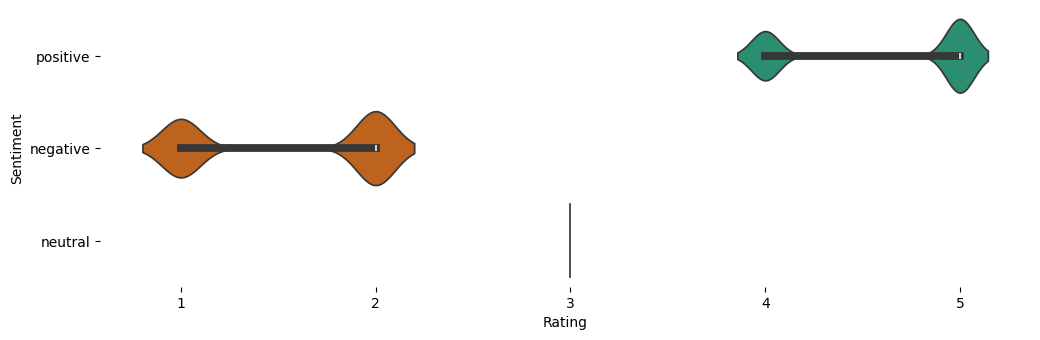

In [ ]:
# @title Sentiment vs Rating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Rating', y='Sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Train-test Split

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional

In [ ]:
# Splitting the data into features and labels
X = df['cleaned_review']  # Input feature
y = df['Sentiment']       # Target labels

# Splitting the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Display the sizes of each split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check the balance of sentiment labels in each set
print("\nTraining set sentiment distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation set sentiment distribution:")
print(y_val.value_counts(normalize=True))
print("\nTest set sentiment distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 16392
Validation set size: 2049
Test set size: 2050

Training set sentiment distribution:
Sentiment
positive    0.736579
negative    0.156845
neutral     0.106576
Name: proportion, dtype: float64

Validation set sentiment distribution:
Sentiment
positive    0.736457
negative    0.156662
neutral     0.106881
Name: proportion, dtype: float64

Test set sentiment distribution:
Sentiment
positive    0.736585
negative    0.157073
neutral     0.106341
Name: proportion, dtype: float64


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((16392,), (2049,), (2050,))

### Handling Class Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(pd.DataFrame(X_train), y_train)
X_train_balanced = X_train_balanced.iloc[:, 0]  # Convert back to Series

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(pd.DataFrame(X_train), y_train)
X_train_balanced = X_train_balanced.iloc[:, 0] # Convert back to Series

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 2.1252430960715674, 1: 3.1276473955352033, 2: 0.4525426536359119}


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 10000  # Maximum vocabulary size
oov_token = "<OOV>"  # Token for out-of-vocabulary words

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train_balanced)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_balanced)
X_valid_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max(len(seq) for seq in X_train_seq)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Display shapes of the padded datasets
print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_valid_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")


# Ensure y_train_balanced, y_val, and y_test are ready for model training
from sklearn.preprocessing import LabelEncoder

# Encode sentiment labels into numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)  # For balanced training data
y_valid_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Training labels shape: {y_train_encoded.shape}")
print(f"Validation labels shape: {y_valid_encoded.shape}")
print(f"Test labels shape: {y_test_encoded.shape}")

Training data shape: (5241, 1861)
Validation data shape: (2049, 1861)
Test data shape: (2050, 1861)
Training labels shape: (5241,)
Validation labels shape: (2049,)
Test labels shape: (2050,)


In [ ]:
# Path to GloVe file (replace with your path)
glove_file_path = "/content/drive/MyDrive/DL/glove.6B.100d.txt"
embedding_dim = 100

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

# Create embedding matrix
word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index)) + 1  # +1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)

Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (10001, 100)


## Stacked LSTM w/ Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D, Input

# Define the LSTM model with stacked layers and attention
input_layer = Input(shape=(max_length,))  # Input layer for sequences

# Embedding layer with pre-trained GloVe embeddings
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,             # GloVe embedding dimensions
    weights=[embedding_matrix],           # Pre-trained GloVe embeddings
    input_length=max_length,              # Max sequence length
    trainable=True                        # Embeddings are trainable
)(input_layer)

# First LSTM layer
lstm_1 = LSTM(64, return_sequences=True)(embedding_layer)

# Second stacked LSTM layer
lstm_2 = LSTM(64, return_sequences=True)(lstm_1)

# Add an Attention Layer
attention = Attention(use_scale=True)([lstm_2, lstm_2])  # Attention over LSTM outputs

# Combine Attention output with LSTM
concatenated = Concatenate()([lstm_2, attention])

# Apply GlobalAveragePooling1D to reduce sequence to a single vector
pooled_output = GlobalAveragePooling1D()(concatenated)

# Dropout layer for regularization
dropout = Dropout(0.3)(pooled_output)

# Dense output layer for multi-class classification
output_layer = Dense(3, activation='softmax')(dropout)

# Define the complete model
lstm_attention_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
lstm_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# Train the model
lstm_attention_history = lstm_attention_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.3471 - loss: 1.7838 - val_accuracy: 0.1069 - val_loss: 1.9957
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.3414 - loss: 1.7182 - val_accuracy: 0.1069 - val_loss: 2.0358
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.3403 - loss: 1.7145 - val_accuracy: 0.1240 - val_loss: 1.9629
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.3973 - loss: 1.6370 - val_accuracy: 0.1747 - val_loss: 1.8668
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.5069 - loss: 1.3795 - val_accuracy: 0.1947 - val_loss: 1.8297
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.5521 - loss: 1.1602 - val_accuracy: 0.1967 - val_loss: 1.3958
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 311ms/step - accuracy: 0.5935 - loss: 0.9293 - val_accuracy: 0.2001 - val_loss: 1.6123
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 287ms/step - accuracy: 0.6625 - loss: 0.7740 - val_accu

In [ ]:
lstm_attention_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1861)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1861, 100)      │      1,000,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1861, 64)       │         42,240 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1861, 64)       │         33,024 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1861, 64)       │              1 │ lstm_1[0][0],          │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1861, 128)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ concatenate[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │            387 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,227,258 (12.31 MB)

 Trainable params: 1,075,752 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,151,506 (8.21 MB)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_test_pred_prob = lstm_attention_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred = y_test_pred_prob.argmax(axis=1)      # Convert probabilities to class labels

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
report = classification_report(
    y_test_encoded, y_test_pred,
    target_names=["Negative", "Neutral", "Positive"]  # Update with your class labels
)
print("\nClassification Report:\n")
print(report)

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Test Accuracy: 0.7293

Classification Report:

              precision    recall  f1-score   support

    Negative       0.66      0.79      0.72       322
     Neutral       0.24      0.54      0.33       218
    Positive       0.96      0.75      0.84      1510

    accuracy                           0.73      2050
   macro avg       0.62      0.69      0.63      2050
weighted avg       0.83      0.73      0.76      2050



### Stacked BiLSTM w/ Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D, Input

# Define the BiLSTM model with stacked layers and attention
input_layer = Input(shape=(max_length,))  # Input layer for sequences

# Embedding layer with pre-trained GloVe embeddings
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,             # GloVe embedding dimensions
    weights=[embedding_matrix],           # Pre-trained GloVe embeddings
    input_length=max_length,              # Max sequence length
    trainable=True                      # Embeddings are not trainable
)(input_layer)

# First BiLSTM layer (Bidirectional LSTM)
bilstm_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)  # return_sequences=True for stacking

# Second stacked BiLSTM layer
bilstm_2 = Bidirectional(LSTM(64, return_sequences=True))(bilstm_1)  # return_sequences=True to output a sequence

# Add an Attention Layer
attention = Attention(use_scale=True)([bilstm_2, bilstm_2])  # Attention over the output of the second BiLSTM

# Combine Attention output with BiLSTM
concatenated = Concatenate()([bilstm_2, attention])

# Apply GlobalAveragePooling1D to reduce sequence to a single vector
pooled_output = GlobalAveragePooling1D()(concatenated)

# Dropout layer for regularization
dropout_layer = Dropout(0.5)(pooled_output)

# Dense output layer for multi-class classification
output_layer = Dense(3, activation='softmax')(dropout_layer)

# Define the complete model
bilstm_attention_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
bilstm_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# Train the BiLSTM model
bilstm_history = bilstm_attention_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - accuracy: 0.3255 - loss: 1.7697 - val_accuracy: 0.1069 - val_loss: 1.9116
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.3275 - loss: 1.7130 - val_accuracy: 0.1196 - val_loss: 2.4473
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 466ms/step - accuracy: 0.4411 - loss: 1.5341 - val_accuracy: 0.1952 - val_loss: 1.8000
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - accuracy: 0.5338 - loss: 1.1624 - val_accuracy: 0.4056 - val_loss: 1.5200
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.6842 - loss: 0.8933 - val_accuracy: 0.2811 - val_loss: 1.4986
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 528ms/step - accuracy: 0.7230 - loss: 0.7892 - val_accuracy: 0.4305 - val_loss: 1.4585
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 77s 468ms/step - accuracy: 0.7965 - loss: 0.5850 - val_accuracy: 0.6506 - val_loss: 0.9703
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 464ms/step - accuracy: 0.8553 - loss: 0.4250 - val_accu

In [ ]:
# Display model architecture
bilstm_attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1861)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1861, 100)      │      1,000,100 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1861, 128)      │         84,480 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 1861, 128)      │         98,816 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1861, 128)      │              1 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1861, 256)      │              0 │ bidirectional_1[0][0], │
│ (Concatenate)             │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ concatenate_1[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │            771 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,552,506 (13.55 MB)

 Trainable params: 1,184,168 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,368,338 (9.03 MB)

In [ ]:
# Predict on the test set (BiLSTM)
y_test_pred_prob_bilstm = bilstm_attention_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred_bilstm = y_test_pred_prob_bilstm.argmax(axis=1)  # Convert probabilities to class labels

# Evaluate BiLSTM model
test_accuracy_bilstm = accuracy_score(y_test_encoded, y_test_pred_bilstm)
print(f"BiLSTM Test Accuracy: {test_accuracy_bilstm:.4f}")

report_bilstm = classification_report(
    y_test_encoded, y_test_pred_bilstm,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nBiLSTM Classification Report:\n")
print(report_bilstm)

65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step
BiLSTM Test Accuracy: 0.7107

BiLSTM Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72       322
     Neutral       0.23      0.59      0.33       218
    Positive       0.95      0.72      0.82      1510

    accuracy                           0.71      2050
   macro avg       0.63      0.68      0.62      2050
weighted avg       0.84      0.71      0.75      2050



## Stacked GRU w/ Attention

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D, Input

# Define the GRU model with stacked layers and attention
input_layer = Input(shape=(max_length,))  # Input layer for sequences

# Embedding layer with pre-trained GloVe embeddings
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],  # vocab_size
    output_dim=embedding_dim,             # GloVe embedding dimensions
    weights=[embedding_matrix],           # Pre-trained GloVe embeddings
    input_length=max_length,              # Max sequence length
    trainable=True                       # Embeddings are not trainable
)(input_layer)

# First GRU layer
gru_1 = GRU(64, return_sequences=True)(embedding_layer)  # return_sequences=True for stacking

# Second stacked GRU layer
gru_2 = GRU(64, return_sequences=True)(gru_1)  # return_sequences=True to output a sequence

# Add an Attention Layer
attention = Attention(use_scale=True)([gru_2, gru_2])  # Attention over the output of the second GRU

# Combine Attention output with GRU
concatenated = Concatenate()([gru_2, attention])

# Apply GlobalAveragePooling1D to reduce sequence to a single vector
pooled_output = GlobalAveragePooling1D()(concatenated)

# Dropout layer for regularization
dropout_layer = Dropout(0.5)(pooled_output)

# Dense output layer for multi-class classification
output_layer = Dense(3, activation='softmax')(dropout_layer)

# Define the complete model
gru_attention_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
gru_attention_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for integer-encoded labels
    metrics=['accuracy']
)

# Train the GRU model
gru_history = gru_attention_model.fit(
    X_train_pad, y_train_encoded,               # Multi-class encoded labels
    validation_data=(X_valid_pad, y_valid_encoded),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,            # Apply class weights
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 0.3294 - loss: 1.8000 - val_accuracy: 0.1069 - val_loss: 2.2804
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.3380 - loss: 1.7423 - val_accuracy: 0.1069 - val_loss: 1.9740
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.3274 - loss: 1.7234 - val_accuracy: 0.1069 - val_loss: 2.1357
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.3556 - loss: 1.6979 - val_accuracy: 0.1869 - val_loss: 1.4661
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 310ms/step - accuracy: 0.4872 - loss: 1.3726 - val_accuracy: 0.4295 - val_loss: 1.1848
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.6068 - loss: 1.0680 - val_accuracy: 0.5735 - val_loss: 1.0379
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.7088 - loss: 0.9252 - val_accuracy: 0.5315 - val_loss: 1.0596
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.7636 - loss: 0.7090 - val_accuracy: 0.692

In [ ]:
# Display model architecture
gru_attention_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1861)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1861, 100)      │      1,000,100 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 1861, 64)       │         31,872 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 1861, 64)       │         24,960 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 1861, 64)       │              1 │ gru_1[0][0],           │
│                           │                        │                │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1861, 128)      │              0 │ gru_1[0][0],           │
│ (Concatenate)             │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ concatenate_2[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │            387 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,171,962 (12.10 MB)

 Trainable params: 1,057,320 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,114,642 (8.07 MB)

In [ ]:

# Predict on the test set (GRU)
y_test_pred_prob_gru = gru_attention_model.predict(X_test_pad)  # Predicted probabilities
y_test_pred_gru = y_test_pred_prob_gru.argmax(axis=1)  # Convert probabilities to class labels

# Evaluate GRU model
test_accuracy_gru = accuracy_score(y_test_encoded, y_test_pred_gru)
print(f"GRU Test Accuracy: {test_accuracy_gru:.4f}")

report_gru = classification_report(
    y_test_encoded, y_test_pred_gru,
    target_names=["Negative", "Neutral", "Positive"]
)
print("\nGRU Classification Report:\n")
print(report_gru)

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step
GRU Test Accuracy: 0.7576

GRU Classification Report:

              precision    recall  f1-score   support

    Negative       0.75      0.78      0.76       322
     Neutral       0.28      0.64      0.39       218
    Positive       0.96      0.77      0.85      1510

    accuracy                           0.76      2050
   macro avg       0.66      0.73      0.67      2050
weighted avg       0.85      0.76      0.79      2050



In [ ]:
# Define a function to display predictions for a few test samples
def display_predictions(model, X_test, y_test, tokenizer, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    for i in sample_indices:
        original_text = tokenizer.sequences_to_texts([X_test[i]])[0]  # Decode the sequence
        actual_sentiment = "Positive" if y_test.iloc[i] == 1 else "Negative"
        predicted_prob = model.predict(X_test_pad[i:i+1])[0][0]
        predicted_sentiment = "Positive" if predicted_prob > 0.5 else "Negative"
        print(f"Original Review: {original_text}")
        print(f"Actual Sentiment: {actual_sentiment}")
        print(f"Predicted Sentiment: {predicted_sentiment} (Confidence: {predicted_prob:.2f})")
        print("-" * 80)

# Display predictions for LSTM
print("\n <<<<<<<<<<<<<<<<<<<<<<<< LSTM MODEL >>>>>>>>>>>>>>>>>>>")
display_predictions(lstm_attention_model, X_test_pad, y_test, tokenizer, num_samples=5)

# Display predictions for BiLSTM
print("\n\n <<<<<<<<<<<<<<<<<<<<<<<< BiLSTM MODEL >>>>>>>>>>>>>>>>>>>")
display_predictions(bilstm_attention_model, X_test_pad, y_test, tokenizer, num_samples=5)

# Display predictions for GRU
print("\n\n <<<<<<<<<<<<<<<<<<<<<<<< GRU MODEL >>>>>>>>>>>>>>>>>>>")
display_predictions(gru_attention_model, X_test_pad, y_test, tokenizer, num_samples=5)


 <<<<<<<<<<<<<<<<<<<<<<<< LSTM MODEL >>>>>>>>>>>>>>>>>>>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Original Review: nice place bad manager nt wrong bad people manager accountant nothing bad people serving client perfectly nice efficient booked room online price travel standard room people night book petite room cheaper got error message website filling credit card information saying transaction <OOV> nothing recorded tried message tried finally went website bookingcom reservation arrived hotel <OOV> told reservation went green told worry nt pay reservation good stayed night know gave petite room n charged standard room booked <OOV> dishonest behavior hotel nice room actually small nice bed perfect clean good room service nice employee left nice night paying desk checked day later discovered charge dollar bank account week travelling mexico came mexico city went hotel make clear met nice guy speaking english asked write email explaining problem answered saying best bring money news money m